In [1]:
# %pip install --upgrade pip --user
# %pip install zarr --user
# %pip install tables --user
# %pip install git+https://github.com/simpeg/simpeg.git@simulation-tdem --user
# %pip install dask dask_jobqueue --user
# %pip install git+https://github.com/simpeg-research/casingSimulations.git@simulation --user

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import discretize
from scipy import sparse as sp
from scipy.constants import mu_0
from SimPEG.utils.SolverUtils import SolverWrapI
import pandas as pd
from pymatsolver import Pardiso, SolverCG
import os
import json
import dask
# import dask_jobqueue
# from dask.distributed import Client

import casingSimulations as casing_sim

import torch

# we are in the midst of upgrading the API, so this is 
# more closely in-line with the upcoming changes
from SimPEG.electromagnetics import time_domain as tdem

%matplotlib inline

In [3]:
SolverICG = SolverWrapI(sp.linalg.cg, checkAccuracy=False)

In [4]:
Solver = Pardiso
solver_opts = {} #{"maxiter": 10}

In [5]:
data_directory = "./experiment1"
df = pd.read_hdf(f"{data_directory}/trial_data.h5", "data")

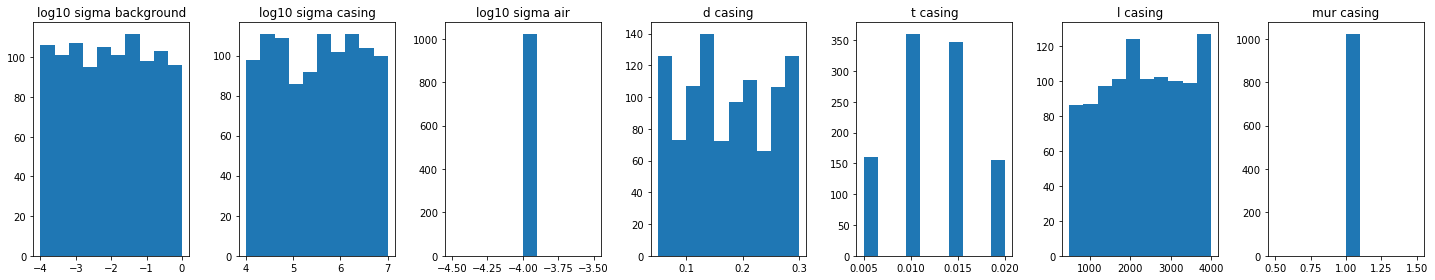

In [6]:
fig, ax = plt.subplots(1,len(df.keys()), figsize=(20, 4))

for i, key in enumerate(df.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [7]:
# pick a single model to try training on 
trial_index = 5  # a 1200 m long well (relatively short --> fast simulations)

trial_directory = f"{data_directory}/trial_{trial_index}"

In [8]:
# generate the 2D model 

with open(f"{trial_directory}/approx_casing.json") as f: 
    params = json.load(f)
model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

with open(f"{trial_directory}/simulation_approx_casing.json") as f:
    simulation_params = json.load(f)
    
sim3D = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
mesh3D = sim3D.mesh

In [9]:
# create a 2D simulation
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))


(-2000, 10)

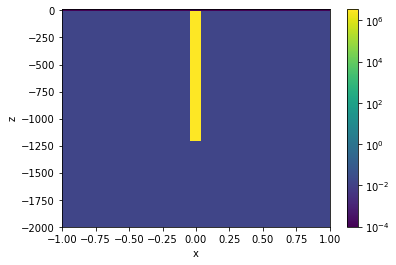

In [10]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    mesh.plotImage(
        sim.sigma, ax=ax, pcolorOpts={"norm":LogNorm()}, mirror=True
    )[0], ax=ax
)
ax.set_xlim([-1, 1])
ax.set_ylim([-2000, 10])

In [11]:
sim.mesh.edgeCurl.shape

(30510, 15282)

In [12]:
def getRHS(sim, src):
    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m

    # we are setting s_e to zero
    rhs = sim.mesh.edgeCurl * (sim.MeMuI * src)
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [13]:
def getRHS_deriv(sim, v=None, adjoint=False):

    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m
    # we are setting s_e to zero
    mesh = sim.mesh
    
    if adjoint:
        if sim._makeASymmetric:
            if v is not None: 
                rhs = sim.MfRho * v
            else:
                rhs = sim.MfRho
        else:
            rhs = v if v is not None else sp.eye(mesh.nF)
        return sim.MeMuI.T * (mesh.edgeCurl.T * rhs)
    
    if v is not None:
        rhs = sim.mesh.edgeCurl * (sim.MeMuI * v)
    else:
        rhs = sim.mesh.edgeCurl * sim.MeMuI
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [14]:
# solve the forward problem 
def fields(sim, source):
    f = np.zeros((sim.mesh.nF, sim.nT+1))

    # this assumes the initial condition is zero. 
    
    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) >
            sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None

        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs = getRHS(sim, source[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs - Asubdiag * f[:, tInd])
        f[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return f

In [15]:
def fields_deriv(sim, v=None, adjoint=False):
    
    if adjoint:
        return fields_deriv_adjoint(sim, v=v)
    
    df_dm_v = np.zeros((sim.mesh.nF, sim.nT+1))

    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) > sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None
        
        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs_deriv = getRHS_deriv(sim, v[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs_deriv - Asubdiag * df_dm_v[:, tInd])
        df_dm_v[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return df_dm_v

In [16]:
def fields_deriv_adjoint(sim, v=None):
    
    df_dmT_v = np.zeros((sim.mesh.nE, sim.nT+1))  # the source is defined on edges

    # timestep to solve forward
    ATinv = None
    for tInd in reversed(range(sim.nT)):
        dt = sim.time_steps[tInd]
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if ATinv is not None and (
            tInd <= sim.nT and abs(dt-sim.timeSteps[tInd + 1]) > sim.dt_threshold
        ):
            ATinv.clean()
            ATinv = None
        
        if ATinv is None:
            AT = sim.getAdiag(tInd).T
            ATinv = Pardiso(AT)    
        
#         ATinv_v = ATinv * v[:, tInd+1]
        if tInd < sim.nT - 1:
            AsubdiagT = sim.getAsubdiag(tInd+1).T
            sol = ATinv * (v[:, tInd+1] - AsubdiagT * sol)
        else: 
            sol = ATinv * v[:, tInd+1]
        rhs_deriv = getRHS_deriv(sim, sol, adjoint=True)  # this is on the nodes of the time mesh
        
        df_dmT_v[:, tInd+1] = rhs_deriv

    # clean factors and return
    ATinv.clean()
    return df_dmT_v

In [17]:
def create_source(sim, model, s, trial_directory):
    # interpolate on to the spatial mesh (lets use exact time for now)
#     z_source = np.load(f"{trial_directory}/z_currents.npy")
    mesh = sim.mesh
    src = np.zeros((mesh.nEy, sim.nT+1))
  
    csx = mesh.hx.min()
    
    xinds = (mesh.gridEy[:, 0] < model.casing_b + csx/2) & (mesh.gridEy[:, 0] > model.casing_b - csx/2)
    zinds = (mesh.gridEy[:, 2] >= model.casing_z.min()) & (mesh.gridEy[:, 2] <= model.casing_z.max())
    src_inds_bool = xinds & zinds
    src_inds = np.where(src_inds_bool)[0]
    
#     P = discretize.utils.interpmat(mesh.gridEy[src_inds, 2], z_source)

    src[src_inds, :] = s
    
    def grad(dy, adjoint=True):
        if adjoint:
            return dy[src_inds, :]
        grd = np.zeros((mesh.nEy, sim.nT+1))
        grd[src_inds, :] = dy
        return grd
    
    return src, grad
                  

In [18]:
def load_trial(trial_directory):
    
    # model parameters
    with open(f"{trial_directory}/casing.json") as f: 
        params = json.load(f)
    casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)
    
    with open(f"{trial_directory}/approx_casing.json") as f: 
        params = json.load(f)
    approx_casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

    model_dict = {
        "casing": casing, 
        "approx_casing": approx_casing
    }
    
    with open(f"{trial_directory}/simulation_approx_casing.json") as f:
        simulation_params = json.load(f)

    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    sim.survey.source_list = sim.survey.source_list # HAck to trigger the validator 
    mesh = sim.mesh
    
    # load up the fields
    fields_dict = {}
    for key in model_dict.keys():
        print(key)
        sim.sigma = model_dict[key].sigma(mesh)
        f = np.load(f"{trial_directory}/{key}_fields.npy")
        fields_dict[key] = sim.fieldsPair(sim)
        fields_dict[key][:, "jSolution", :] = f
    
    return model_dict, fields_dict, sim, mesh 

In [19]:
def get_j_inds(
    mesh, sim, x_bounds=np.r_[1, 2000], z_bounds=np.r_[-2000, 0]
):
  
    inds_Fx = (
        (mesh.gridFx[:, 0] > x_bounds.min()) & (mesh.gridFx[:, 0] < x_bounds.max()) &
        (mesh.gridFx[:, 2] > z_bounds.min()) & (mesh.gridFx[:, 2] < z_bounds.max()) 
    )
    
    inds_Fx = np.kron(np.ones(sim.nT+1, dtype=bool), inds_Fx)
    
    inds_Fz = (
        (mesh.gridFz[:, 0] > x_bounds.min()) & (mesh.gridFz[:, 0] < x_bounds.max()) &
        (mesh.gridFz[:, 2] > z_bounds.min()) & (mesh.gridFz[:, 2] < z_bounds.max()) 
    )
    inds_Fz = np.kron(np.ones(sim.nT+1, dtype=bool), inds_Fz)
    
    inds = np.hstack([inds_Fx, inds_Fz])

    return inds
    

In [20]:
def run_forward(model, mesh, sim, source_vec):
#     trial_directory = f"{data_directory}/trial_{trial_ind}"
#     model, mesh, sim = load_trial(trial_directory)
    
    source, source_grad = create_source(sim, model, source_vec, trial_directory)
    f = fields(sim, source)
#     P = get_j_interpolation_mat(trial_directory, mesh)
    j_compare = discretize.utils.mkvc(f)
    
    def grad(dy, adjoint=True):  
        if adjoint: 
            v = dy
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            f_deriv = fields_deriv_adjoint(sim, v)
            return source_grad(f_deriv, adjoint=True)
        f_deriv = fields_deriv(sim, source_grad(dy, adjoint=False))
        return discretize.utils.mkvc(f_deriv)
        
    return j_compare, grad

# set up a simple test example 

In [21]:
def waveform(t, t_peak=5e-3, width=10, amplitude=1):
    t = np.log10(t)
    t_peak = np.log10(t_peak)
    width = np.log10(width)
    return amplitude * np.exp(-(t - t_peak)**2/(2*width**2))

def sigmoid(x, x0=0, slope=1):
    return np.arctan(slope * (x-x0))/np.pi + 0.5

def depth_distribution(z, dz=200, slope=1e-1):
    return sigmoid(z, model.casing_z.min() + dz, slope) * sigmoid(-z, -(model.casing_z.max() - dz), slope)

def source_sm(mesh, t, z):
    sm = np.zeros(mesh.nE)
    sm = np.outer(depth_distribution(z), waveform(t))
    
    return sm

In [22]:
# z = np.load(f"{trial_directory}/z_currents.npy")
csx = mesh.hx.min()
xinds = (mesh.gridEy[:, 0] < model.casing_b + csx/2) & (mesh.gridEy[:, 0] > model.casing_b - csx/2)
zinds = (mesh.gridEy[:, 2] >= model.casing_z.min()) & (mesh.gridEy[:, 2] <= model.casing_z.max())
src_inds_bool = xinds & zinds
src_inds = np.where(src_inds_bool)[0]
z = mesh.gridEy[src_inds, 2]

In [23]:
src_vec = source_sm(mesh, sim.times, z)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'z')

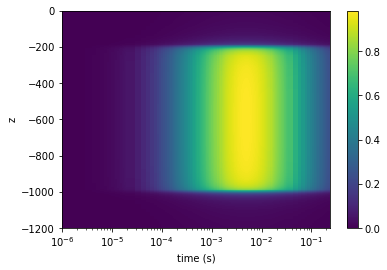

In [24]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.pcolormesh(sim.times, z, src_vec), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [25]:
def test_source(source):   
    source = source.reshape(len(z), sim.nT+1, order="F")
    src, grad = create_source(sim, model, source, trial_directory)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint: 
            dy = dy.reshape(len(z), sim.nT+1, order="F")
        else:
            dy = dy.reshape(mesh.nE, sim.nT+1, order="F")
        return discretize.utils.mkvc(grad(dy, adjoint))
    
    return discretize.utils.mkvc(src), src_deriv

src_vec[:, 0] = 0
x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_source,
    x0=x0,
    num=4, 
    plotIt=False, 
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.140e+01     5.699e-15      nan
 1   1.00e-02    2.140e+00     4.676e-15      0.086
 2   1.00e-03    2.140e-01     4.682e-15      -0.001
 3   1.00e-04    2.140e-02     4.651e-15      0.003
========================= PASS! =========================
Yay passed!



True

In [26]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(len(z), sim.nT+1, order="F"))
src, src_deriv = test_source(src_vec)

v = np.random.rand(len(z)*(sim.nT+1))
w = np.random.rand(mesh.nE*(sim.nT+1))

a = w.T.dot(discretize.utils.mkvc(src_deriv(v.reshape(len(z), sim.nT+1, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(src_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.150e+04, 1.150e+04, 0.000e+00


In [27]:
def test_rhs(source):   
    source = source.reshape(len(z), (sim.nT+1), order="F")
    src, grad_src = create_source(sim, model, source, trial_directory)
    rhs = getRHS(sim, src)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint:
            dy = dy.reshape(len(z), (sim.nT+1), order="F")
            return discretize.utils.mkvc(getRHS_deriv(sim, grad_src(dy, adjoint), adjoint))
        else: 
            dy = dy.reshape(mesh.nF, (sim.nT+1), order="F")
            return grad_src(getRHS_deriv(sim, dy, adjoint), adjoint)        
    
    return discretize.utils.mkvc(rhs), src_deriv

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_rhs,
    x0=0*x0,
    dx=x0,
    num=8, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.250e+11     1.617e-05      nan
 1   1.00e-02    1.250e+10     1.710e-06      0.976
 2   1.00e-03    1.250e+09     1.684e-07      1.007
 3   1.00e-04    1.250e+08     1.581e-08      1.028
 4   1.00e-05    1.250e+07     1.722e-09      0.963
 5   1.00e-06    1.250e+06     1.700e-10      1.006
 6   1.00e-07    1.250e+05     1.582e-11      1.031
 7   1.00e-08    1.250e+04     1.711e-12      0.966
========================= PASS! =========================
The test be workin!



True

In [28]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(len(z), sim.nT+1, order="F"))
rhs, rhs_deriv = test_rhs(src_vec)

v = np.random.rand(len(z)*(sim.nT+1))
w = np.random.rand(mesh.nF*(sim.nT+1))

a = w.T.dot(discretize.utils.mkvc(rhs_deriv(v.reshape(len(z), (sim.nT+1), order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(rhs_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.192e+14, 1.192e+14, 4.688e-02


In [29]:
src_sm, _ = create_source(sim, model, src_vec.reshape(len(z), sim.nT+1, order="F"), trial_directory)

def test_forward(src_sm):
    src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
    j = fields(sim, src_sm)
    
    def j_deriv(v, adjoint=False):
        if not adjoint:
            v = v.reshape(mesh.nEy, sim.nT+1, order="F")
            return discretize.utils.mkvc(fields_deriv(sim, v, adjoint))
        else:
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            return fields_deriv(sim, v, adjoint)
    return discretize.utils.mkvc(j), j_deriv

x0 = discretize.utils.mkvc(src_sm)
discretize.Tests.checkDerivative(
    test_forward,
    x0=0*x0,
    num=8, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


/Users/lindseyjh/git/python_symlinks/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


 0   1.00e-01    3.823e+08     1.233e-03      nan
 1   1.00e-02    3.823e+07     1.830e-04      0.829
 2   1.00e-03    3.823e+06     3.872e-05      0.675
 3   1.00e-04    3.823e+05     1.343e-06      1.460
 4   1.00e-05    3.823e+04     1.113e-07      1.081
 5   1.00e-06    3.823e+03     9.381e-09      1.074
 6   1.00e-07    3.823e+02     1.170e-06      -2.096
 7   1.00e-08    3.823e+01     1.203e-10      3.988
========================= PASS! =========================
Testing is important.



True

In [30]:
# adjoint test

j, j_deriv = test_forward(src_sm)

v = np.random.rand(np.prod(src_sm.shape))
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v, adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

7.402e+11, 7.402e+11, 4.442e-01


In [31]:
model_dict, fields_dict, sim3D, mesh3D = load_trial(trial_directory)

casing
approx_casing


In [32]:
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))

def test_forward_full(src_vec):
    src_vec = src_vec.reshape(len(z), sim.nT+1, order="F")
    j, j_deriv = run_forward(model_dict["approx_casing"], mesh, sim, src_vec)
    
    def grad(v):
        v = v.reshape(len(z), sim.nT+1, order="F")
        return discretize.utils.mkvc(j_deriv(v, adjoint=False))
    return discretize.utils.mkvc(j), grad

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_forward_full,
    x0=x0,
    num=8, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


/Users/lindseyjh/git/python_symlinks/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


 0   1.00e-01    2.185e+05     1.298e-03      nan
 1   1.00e-02    2.185e+04     1.517e-03      -0.068
 2   1.00e-03    2.185e+03     1.460e-03      0.017
 3   1.00e-04    2.185e+02     3.313e-03      -0.356
 4   1.00e-05    2.185e+01     1.438e-03      0.363
 5   1.00e-06    2.185e+00     2.576e-03      -0.253
 6   1.00e-07    2.185e-01     1.584e-03      0.211
 7   1.00e-08    2.193e-02     1.808e-03      -0.057
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
Coffee break?



False

In [33]:
# adjoint test

src_vec = src_vec.reshape(len(z), sim.nT+1, order="F")
j, j_deriv = run_forward(model_dict["approx_casing"], mesh, sim, src_vec)

v = np.random.rand(len(z)*(sim.nT+1))
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v.reshape(len(z), sim.nT+1, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

err = a-b
if np.linalg.norm(err)/np.linalg.norm(a) < 1e-10:
    passing = True
else: 
    passing = False
    
print(
    f"{np.linalg.norm(a):1.3e}, "
    f"{np.linalg.norm(b):1.3e}, "
    f"{np.linalg.norm(err):1.3e}, "
    f"{'passing :)' if passing is True else 'failing :('}"
)

8.639e+09, 8.639e+09, 3.274e-02, passing :)


In [34]:
src_sm, _ = create_source(sim, model, src_vec, trial_directory)
src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
j = fields(sim, src_sm)

Text(0.5, 1.0, 'current density, t=1.2e-01ms')

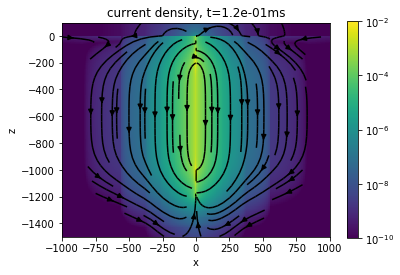

In [35]:
tind = 30
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveF2CCV * j[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax, mirror=True,
    range_x=np.r_[-1000, 1000], 
    range_y=np.r_[-1500, 100],
    sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-10, 1e-2], 
    stream_threshold = 1e-10
)
ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"current density, t={sim.times[tind]*1e3:1.1e}ms")

Text(0.5, 1.0, 'source term, t=1.0e-02ms')

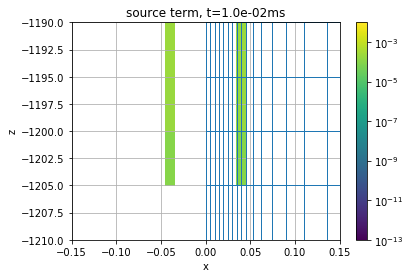

In [36]:
tind = 10
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveE2CC * src_sm[:, tind], 
#     view="vec",
#     vType="CCv",
    ax=ax, mirror=True,
    range_x=0.15*np.r_[-1, 1], 
    range_y=np.r_[-1210, -1190], #10*np.r_[-1, 1],
#     sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-13, 1e-2], 
#     stream_threshold = 1e-13
)
mesh.plotGrid(ax=ax)
# ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"source term, t={sim.times[tind]*1e3:1.1e}ms")

In [37]:
class TmpForward:
    
    def __init__(self, model, mesh, sim):
        self.model = model
        self.mesh = mesh
        self.sim = sim
    
    def forward(self, source_vec):
        if len(source_vec.shape) <= 1: 
            sourvce_vec = source_vec.reshape(len(z), self.sim.nT + 1, order="F")
        source, source_grad = create_source(self.sim, self.model, source_vec, trial_directory)        
        self.source_grad = source_grad
        
        # compute fields 
        f = fields(self.sim, source)
        
        if getattr(self, 'inds', None) is None:
            inds = get_j_inds(
                self.mesh, sim, x_bounds=x_bounds, z_bounds=z_bounds
            )
            self.inds = inds
        
        # project data
        j_compare = (discretize.utils.mkvc(f))[self.inds]
        return j_compare

    def grad(self, dy):
        if len(dy.shape) <= 1: 
            dy = dy.reshape(len(z), self.sim.nT + 1, order="F")
        src_grad = self.source_grad(dy, adjoint=False)
        f_deriv = fields_deriv(self.sim, src_grad)
        grad = discretize.utils.mkvc(f_deriv)[self.inds]
        return grad
    
    def adjoint(self, dy):
        inds = self.inds
        v = np.zeros(self.mesh.nF*(self.sim.nT+1))
        v[inds] = dy
        v = v.reshape(self.mesh.nF, self.sim.nT+1, order="F")
        f_deriv = fields_deriv_adjoint(self.sim, v)
        grad = self.source_grad(f_deriv, adjoint=True)
        return grad

In [38]:
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))

tmp_forward = TmpForward(model, mesh, sim)

def test_forward(src):
    src = src.reshape(len(z), sim.nT+1, order="F")
    data = tmp_forward.forward(src)
    
    def grad(v):
        v = v.reshape(len(z), sim.nT+1, order="F")
        return tmp_forward.grad(v)
    return data, grad

x0 = np.zeros(len(z)*(sim.nT+1))
discretize.Tests.checkDerivative(
    test_forward,
    x0=x0,
    num=8, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


NameError: name 'x_bounds' is not defined

In [ ]:
# adjoint test

src_vec = src_vec.reshape(len(z), sim.nT+1, order="F")

j = tmp_forward.forward(src_vec)
v = np.random.rand(len(z)*(sim.nT+1))
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(tmp_forward.grad(v.reshape(len(z), sim.nT+1, order="F"))))
b = v.T.dot(discretize.utils.mkvc(tmp_forward.adjoint(w)))

err = a-b
if np.linalg.norm(err)/np.linalg.norm(a) < 1e-10:
    passing = True
else: 
    passing = False
    
print(
    f"{np.linalg.norm(a):1.3e}, "
    f"{np.linalg.norm(b):1.3e}, "
    f"{np.linalg.norm(err):1.3e}, "
    f"{'passing :)' if passing is True else 'failing :('}"
)

# Set up ML pipeline

In [ ]:
dtype = torch.float64
device = torch.device("cpu")

In [ ]:
nspatial = len(z)
ntimes = sim.nT + 1
nsrcz = len(z)

x_bounds = np.r_[5, 1000]
z_bounds = np.r_[-2000, 0]

In [ ]:
class ForwardSimulation(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, source_vec): #, trial_ind):
#         trial_ind = tri
#         trial_directory = f"{data_directory}/trial_{trial_ind}"
        
        # load up objects 
#         model, mesh, sim = load_trial(trial_directory)
        
        ctx.model = model
        ctx.mesh = mesh
        ctx.sim = sim

        # create source 
        source, source_grad = create_source(sim, model, source_vec.data.numpy(), trial_directory)
#         rhs = getRHS(sim, source)
        
        ctx.source_grad = source_grad
        
        # compute fields 
        f = fields(sim, source)
        
        if getattr(ctx, 'inds', None) is None:
            inds = inds = get_j_inds(
                mesh, sim, x_bounds=x_bounds, z_bounds=z_bounds
            )
            ctx.inds = inds
        
        # project data
        j_compare = (discretize.utils.mkvc(f))[ctx.inds]
        
        if dtype == torch.float32:
            return torch.from_numpy(j_compare).float()
        return torch.from_numpy(j_compare).double()

    @staticmethod
    def backward(ctx, dy): 
        inds = ctx.inds
        v = np.zeros(ctx.mesh.nF*(ctx.sim.nT+1))
        v[inds] = dy.data.numpy()
        v = v.reshape(ctx.mesh.nF, ctx.sim.nT+1, order="F")
        f_deriv = fields_deriv_adjoint(ctx.sim, v)
        grad = ctx.source_grad(f_deriv, adjoint=True)

        if dtype == torch.float32:
            return torch.from_numpy(grad).float()
        return torch.from_numpy(grad).double()


In [ ]:
# class CasingData(torch.utils.data.Dataset):
#     def __init__(self, directory, trial_indices):
#         self.directory = directory
#         self.trial_indices = trial_indices
        
#     def __len__(self):
#         return len(self.trial_indices)
    
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
        
        

In [ ]:
# source, source_deriv = create_source(sim, model, src_vec, trial_directory)
# rhs = getRHS(sim, source)

# trial_ind = 10
# trials = [trial_ind]

# jd_numpy = np.load(f"{trial_directory}/j_difference.npy")

In [ ]:
# plt.hist(np.log10(np.abs(jd_numpy)), 20);

In [ ]:
jd_numpy3D = fields_dict["casing"][:, "j", :] - fields_dict["approx_casing"][:, "j", :]

In [ ]:
jd_x = (jd_numpy3D[:mesh3D.nFx, :]).reshape(np.hstack([mesh3D.vnFx, np.r_[sim.nT+1]]), order="F")
jd_z = (jd_numpy3D[mesh3D.vnF[:2].sum():, :]).reshape(np.hstack([mesh3D.vnFz, np.r_[sim.nT+1]]), order="F")

# grab a slice through theta
theta_ind = 3
jd_numpy = np.hstack([
    discretize.utils.mkvc(jd_x[:, theta_ind, :, :]),
    discretize.utils.mkvc(jd_z[:, theta_ind, :, :]),
])

# select inds away from the well 
inds = get_j_inds(
    mesh, sim, x_bounds=x_bounds, z_bounds=z_bounds
)
jd_numpy = jd_numpy[inds]

In [ ]:
def convert_to_torch_sparse(mat):
    mat = mat.tocoo()
    
    values = mat.data
    indices = np.vstack((mat.row, mat.col))

    # create pytorch sparse matrix
    i = torch.LongTensor(indices)
    
    if dtype == torch.float32: 
        v = torch.FloatTensor(values)
    else:
        v = torch.DoubleTensor(values)
    shape = mat.shape
    
    if dtype == torch.float32: 
        return torch.sparse.FloatTensor(i, v, torch.Size(shape))
    return torch.sparse.DoubleTensor(i, v, torch.Size(shape))

In [ ]:
Dtime = discretize.utils.sdiag(1./sim.time_mesh.hx) * discretize.utils.ddx(sim.nT)
Dtime_torch = convert_to_torch_sparse(Dtime)

# z_currents = np.load(f"{trial_directory}/z_currents.npy")
Dz = discretize.utils.sdiag(1./np.diff(z)) * discretize.utils.ddx(len(z)-1)
Dz_torch = convert_to_torch_sparse(Dz)

In [ ]:
floor = 1e-10
print((np.abs(jd_numpy)>floor).sum() / len(jd_numpy))

In [ ]:
jd = torch.from_numpy(jd_numpy)

std = 0.05 
w = torch.from_numpy(1./(std * np.abs(jd_numpy) + floor))

forward = ForwardSimulation.apply

if dtype == torch.float64:
    jd = jd.double()
    w = w.double() 
else:
    jd = jd.float()
    w = w.float()
    
s0_scaling = 1e-4
learning_rate = 1e-5

plt.hist(1./(std * np.abs(jd_numpy) + floor));
# optimizer = torch.optim.SGD(s0, lr=learning_rate)

In [ ]:
torch.manual_seed(2019)

In [ ]:
# %%time
max_iter = 20
beta = None
beta_factor = 0
beta_cooling = 0.5
beta_cool_every = np.inf

alpha_s = 1e-2
alpha_t = sim.time_mesh.hx.min()
alpha_z = 1

s0 = torch.zeros(nspatial, ntimes, dtype=dtype, device=device, requires_grad=True)

# estimate beta
if beta is None:
    s0_tmp = torch.randn(nspatial, ntimes, dtype=dtype, device=device, requires_grad=True)
    j_pred = forward(s0_scaling * s0_tmp)
    dmisfit = 1./len(jd) * (w.mul(j_pred - jd)).pow(2).sum()
#     dmisfit = ((j_pred - jd)).pow(2).sum()
    regularization = (
        alpha_s * s0_tmp.pow(2).sum() + 
        alpha_t * Dtime_torch.mm(s0_tmp.T).pow(2).sum() + 
        alpha_z * Dz_torch.mm(s0_tmp).pow(2).sum()
    )
    beta = beta_factor * dmisfit.item() / regularization.item()

# for i in range(max_iter):
i = 0
while dmisfit.data.numpy() > 1: 
    s_iter = s0_scaling * s0
    j_pred = forward(s_iter)
    dmisfit = 1./len(jd) *(w.mul(j_pred - jd)).pow(2).sum()
#     dmisfit = ((j_pred - jd)).pow(2).sum()
    smallness = alpha_s * s0.pow(2).sum()
    smooth_time = alpha_t * Dtime_torch.mm(s0.T).pow(2).sum()
    smooth_depth = alpha_z * Dz_torch.mm(s0).pow(2).sum()

    regularization = (
        smallness + 
        smooth_time + 
        smooth_depth
    )
    
    if np.mod(i, beta_cool_every) == 0:
        beta *= beta_cooling

    loss = dmisfit + beta * regularization

    print(
        f"{i}: "
        f"dmisfit: {dmisfit.item():1.2e}, "
        f"beta: {beta:1.2e}, "
#         f"reg: {regularization.item():1.2e}, "
        f"beta*reg: {beta * regularization.item():1.2e}, "
        f"small: {alpha_s * smallness.item():1.2e}, "
        f"smooth time: {alpha_t * smooth_time.item():1.2e}, "
        f"smooth depth: {alpha_z * smooth_depth.item():1.2e}, "
        f"loss: {loss.item():1.2e}"
    )

#     optimizer.zero_grad()
    loss.backward()
#     optimizer.step()
    with torch.no_grad():
        if i < 2:
            s0 -= 10 * learning_rate * s0.grad
        else:

#         maxIterCG = 20
#         tolCG = 1e-1
#         s0_numpy = s0.data.numpy()
#         s0_grad_numpy = s0.grad.numpy()
#         nbfgs = 10

#         bfgs = 

#         H = sp.linalg.LinearOperator(
#             (nspatial*ntimes, nspatial*ntimes), lambda v: 2*tmp_forward.adjoint(tmp_forward.grad(v)), dtype=s0_numpy.dtype
#         )

#         Hinv =  SolverCG(H, tol=tolCG, maxiter=maxIterCG) 

#         step = (Hinv * (discretize.utils.mkvc(s0_grad_numpy))).reshape((nspatial, ntimes), order="F")
#         s0 -= torch.from_numpy(step).double()
            s0 -= learning_rate * s0.grad

            s0.grad.zero_()
        
    i += 1
    if i >= max_iter:
        break
    
#     beta = beta_cooling * beta

In [ ]:
fig, ax = plt.subplots(1, 1)

# z = np.load(f"{trial_directory}/z_currents.npy")
plotme = s0_scaling * s0.data.numpy()
clim = np.r_[1e-4, 1] * np.max(np.abs(plotme))
norm = Normalize(
#         clim[0] if clim is not None else
#         np.max([1e-20, np.min(np.absolute(plotme))]),
        vmin = -clim[1], vmax=clim[1]
    )
    
plt.colorbar(ax.pcolormesh(sim.times, z, plotme, cmap="BrBG_r",  norm=norm), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [ ]:
fig, ax = plt.subplots(1, 1)

cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=sim.time_mesh.vectorCCx[0], vmax=sim.time_mesh.vectorCCx[-1])
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plotme = s0_scaling * s0.data.numpy()

for time_ind in range(sim.nT)[::int(sim.nT/20)]:
    color = scalar_map.to_rgba(sim.time_mesh.vectorCCx[time_ind])
    ax.plot(z, plotme[:, time_ind], color=color)

ax.set_xlim(z.max(), z.min())

cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cb = plt.colorbar(scalar_map, cbar_ax)
cb.set_label('time (s)')
cb.ax.invert_yaxis()

In [ ]:
fig, ax = plt.subplots(1, 1)

cm = plt.get_cmap('viridis')
c_norm = Normalize(vmin=z.min(), vmax=z.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plotme = s0_scaling * s0.data.numpy()

for z_ind in range(len(z))[::int(len(z)/20)]:
    color = scalar_map.to_rgba(z[z_ind])
    ax.semilogx(sim.time_mesh.vectorNx, plotme[z_ind, :], color=color)

# ax.set_xlim(z.max(), z.min())

cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cb = plt.colorbar(scalar_map, cbar_ax)
cb.set_label('z (m)')
cb.ax.invert_yaxis()

In [ ]:
# load up objects 
# model, mesh, sim = load_trial(trial_directory)
src, _ = create_source(sim, model, s0_scaling * s0.data.numpy(), trial_directory)

In [ ]:
tind = 20
plotme = mesh.aveE2CC * src[:, tind]

clim = np.r_[1e-4, 1] * np.max(np.abs(plotme))
norm = Normalize(
#         clim[0] if clim is not None else
#         np.max([1e-20, np.min(np.absolute(plotme))]),
        vmin = -clim[1], vmax=clim[1]
    )

fig, ax = plt.subplots(1, 1)
plt.colorbar(mesh.plotImage(
    plotme, 
    mirror=True, 
    mirror_data=-1*plotme,
    pcolorOpts={"norm": norm, "cmap": "BrBG_r"},
    ax=ax
)[0], ax=ax)

ax.set_title(f"t={sim.times[tind]:1.1e}ms")

ax.set_xlim(0.25*np.r_[-1, 1])
ax.set_ylim(np.r_[-2000, 50])

In [ ]:
j_rec = fields(sim, src)

model_names = list(model_dict.keys())
# sim.survey.source_list = sim.survey.source_list
viewer = casing_sim.FieldsViewer(
    mesh=mesh3D, model_parameters_dict=model_dict, survey_dict={key: sim3D.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

In [ ]:
tind = 40
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

xlim = np.r_[-1000, 1000]
zlim = np.r_[-1500, 100]
sample_grid = np.r_[5., 5.]
clim = np.r_[1e-12, 1e-6]

out = mesh.plotImage(
    mesh.aveF2CCV * j_rec[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax[0], mirror=True,
    range_x=xlim, 
    range_y=zlim,
    sample_grid = sample_grid,
    pcolorOpts={"norm":LogNorm()},
    clim=clim, 
    stream_threshold=clim.min()
)

plt.colorbar(out[0], ax=ax[0])

ax[0].set_title(f"recovered, t={sim.times[tind]*1e3:1.1e}ms")


out2 = viewer.plot_cross_section(
    ax=ax[1], clim=clim, zlim=zlim,
    xlim=xlim,
    view='j', theta_ind=3, time_ind=tind, 
    model_key='approx_casing', show_cb=True, casing_outline=False,
    prim_sec="secondary"
#     stream_opts={"density":0.75, "color": "k", "arrowsize": 2}
)
# ax[1].set_ylim(np.r_[-max_depth, top])
ax[1].set_ylabel('z (m)')
ax[1].set_title(f"true , t={sim.times[tind]*1e3:1.1e}ms")

for a in ax:
    a.set_aspect(1)

In [ ]:
j_pred_plot = j_pred.data.numpy()
jd_plot = jd.data.numpy()
plt.plot(jd_plot)
plt.plot(j_pred_plot)

In [ ]:
np.sum((j_pred_plot - jd_plot)**2)